# Задача

Подготовить таблицу, содержащую:

1. Число выявленных режимов работы оборудования
1. Точки переключения (время) режимов работы с указанием номера старого и нового режима и/или его типа (стационарный /не стационарный)
1. Характерные режимы работы агрегата, а также автоматически выявлены и размечены (по времени) все участки нестационарного режима (режима перехода из одного стационарного в другой стационарный).
1. Успешность работы алгоритма оценивается по совпадению результатов с оценкой эксперта по рассматриваемому виду оборудования.

# Критерии оценки

1. общее число выявленных режимов, число «типовых» (схожих) режимов;
1. основные характеристики режимов (стабильные параметры, изменяющиеся параметры, диапазоны параметров);
1. скорость обработки данных.

In [1]:
from math import nan

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from utils import TARGET_FEATURE, FIGSIZE, DATAFILE_NAMES, load, target_split

In [5]:
dfs = [load(x) for x in DATAFILE_NAMES]
dfs[0].info()
dfs[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243360 entries, 2021-10-14 00:00:00 to 2022-03-31 23:59:00
Columns: 208 entries, 1 to target
dtypes: float32(208)
memory usage: 195.0 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55441 entries, 2022-07-01 00:00:00 to 2022-08-08 12:00:00
Columns: 338 entries, 1 to target
dtypes: float32(338)
memory usage: 71.9 MB


#### Поиск пропущенных значений

In [6]:
def temp1(df, text):
    print((f"Пропущенных значений {text}: {df.isna().sum().sum()} / {df.shape[0]} "
            f"({df.isna().sum().sum() / df.shape[0]:.1%})"))

def temp2(df):
    temp1(df.drop(columns=TARGET_FEATURE), 'без таргета')
    temp1(df, 'таргета')

temp2(dfs[0])
temp2(dfs[1])

Пропущенных значений без таргета: 0 / 243360 (0.0%)
Пропущенных значений таргета: 137041 / 243360 (56.3%)
Пропущенных значений без таргета: 0 / 55441 (0.0%)
Пропущенных значений таргета: 14581 / 55441 (26.3%)


#### Оценка уникальных таргетов

In [7]:
# check that time step is only one
if len(np.unique(np.diff(dfs[0].index))) == 1:
    step = round(float(np.unique(np.diff(dfs[0].index))[0]) * 1e-9, 4)
    print(f'шаг по времени: {step} с')

def temp(df):
    t = df[TARGET_FEATURE].value_counts()
    df0 = pd.concat([t, (t / t.sum() * 100).round(4), (t / df.shape[0] * 100).round(4), (t * step / 60).astype(int)], axis=1)
    df0.columns = ['Абс. кол-во', 'Отн. УР, %', 'Отн. всего, %', 'Время, мин']
    print(df0)

temp(dfs[0])
temp(dfs[1])

шаг по времени: 60.0 с
      Абс. кол-во  Отн. УР, %  Отн. всего, %  Время, мин
1.0         66183     62.2495        27.1955       66183
17.0        16160     15.1995         6.6404       16160
15.0         6535      6.1466         2.6853        6535
13.0         2091      1.9667         0.8592        2091
2.0          1991      1.8727         0.8181        1991
7.0          1745      1.6413         0.7170        1745
22.0         1534      1.4428         0.6303        1534
5.0          1456      1.3695         0.5983        1456
19.0          953      0.8964         0.3916         953
26.0          872      0.8202         0.3583         872
4.0           778      0.7318         0.3197         778
12.0          748      0.7035         0.3074         748
11.0          734      0.6904         0.3016         734
6.0           648      0.6095         0.2663         648
14.0          600      0.5643         0.2465         600
27.0          529      0.4976         0.2174         529
8.0     

Краткие выводы:

1. Очень много режимов.
1. Очень сильный дизбаланс.

#### Изучение графиков

Есть ли смысл? Сотни непонятных признаков и десятки режимов.

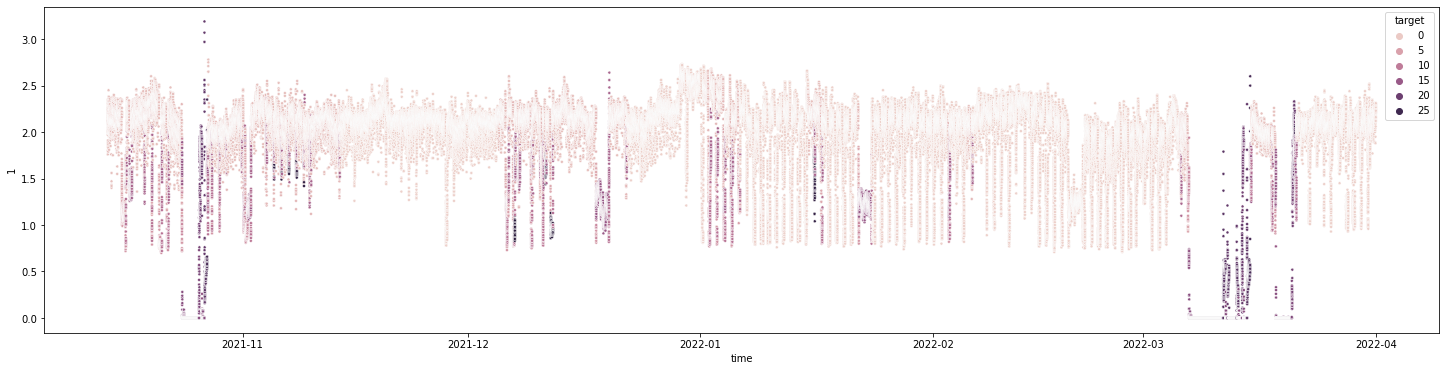

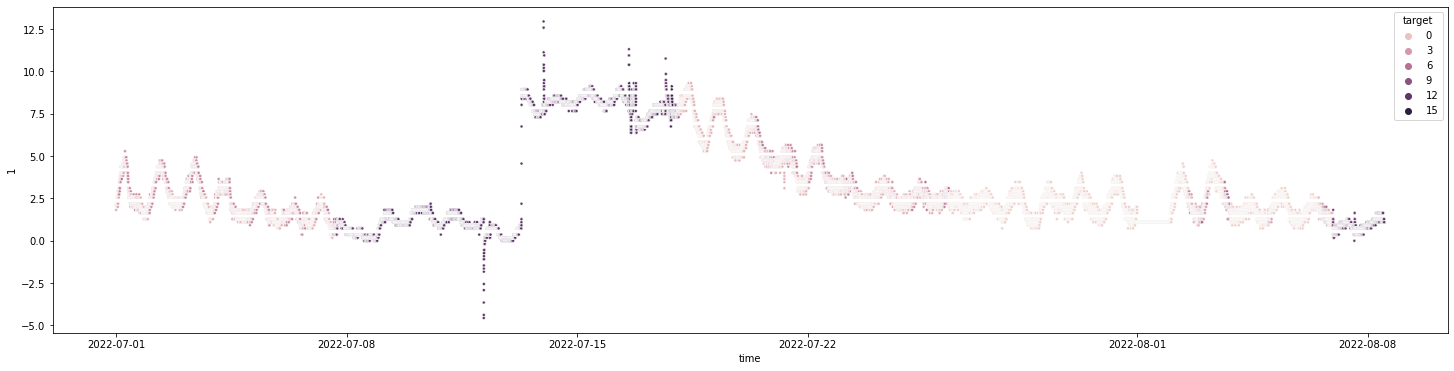

In [8]:
def temp(df, col):
    _, ax = plt.subplots(figsize=FIGSIZE)
    sns.scatterplot(x=df.index, y=df[col], hue=df[TARGET_FEATURE].fillna(-1), ax=ax, marker='.', linewidths=0.1)
    plt.show()

# look at some features
temp(dfs[0], 1)
temp(dfs[1], 1)

#### Изучение строк

In [9]:
for i in (0, 10000):
    print(*map(lambda x: f"{x:4.3g}", dfs[0].iloc[i]), end='\n'*2)

2.26 1.14 -0.09 -0.51 2.56    1 0.88 0.84 0.06 8.14 20.6  301 1.62 9.07 9.16 15.4 -0.09 -0.15  116 6.04 1.03e+03  301 4.31e+03 1.63 1.64 20.6 8.07 12.7 15.8 9.02  137 2.01e+03 -0.94 57.2 11.4 22.9 0.04 0.06 1.02 0.65 78.1 1.03e+03 8.05 20.7 20.7    0  300 8.15  301 -0.94 9.16 1.63 1.63 1.62    0   50 0.07 0.04  806 -0.63 -0.62 -0.95 -0.95 -0.95 -0.95 20.6 20.6  301  301  174  162  171  456  456  453  137  261  442  384  373  277   36   32 27.5 27.7 41.1  164 64.9 38.5   66  154 38.7 13.1 12.7  166   60 65.3 58.2 80.8 48.1 48.5 47.8 47.8  166 1.62 1.96 0.294 1.12 0.076 8.17 20.4  301 1.62 8.96 8.99 15.6 -0.082 -0.043  154 1.04e+03  301 4.26e+03 1.61 1.61 20.4 8.11 12.1 15.8 8.58  135 2e+03 -0.958 53.1 10.6 21.5 0.037 0.071 0.328 1.22 83.3 6.02 8.12 -0.955  301 1.04e+03 8.12 20.4 20.4    0 1.62 1.61 1.61 8.98  301 1.01  1.7 0.083 -0.541 1.19   50 0.513 0.146 -0.605 -0.676 -0.944 -0.945 -0.945 -0.947 20.5 20.5  300  301  154  162  170  453  459  459  151  273  448  401  398  294 35.5 34.1

#### Попытка определить является ли режимом простой оборудования и есть ли он вообще

In [10]:
def temp(t, n):
    _, ax = plt.subplots(figsize=FIGSIZE)
    hue = dfs[n][TARGET_FEATURE].fillna(-1).loc[t.index]
    hue = hue.astype('category').cat.codes
    sns.scatterplot(x=t.index, y=t, hue=hue, ax=ax, marker='.', linewidths=0.01)

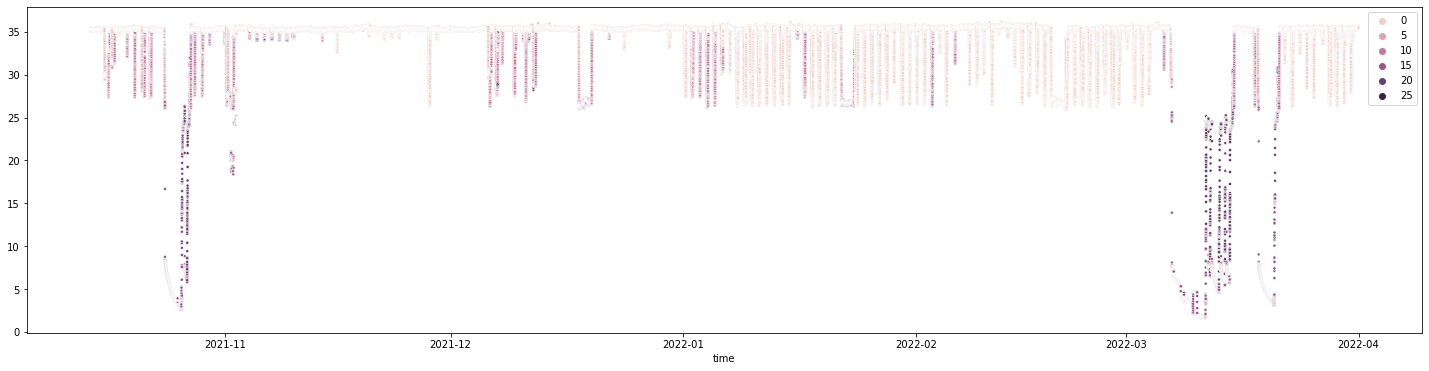

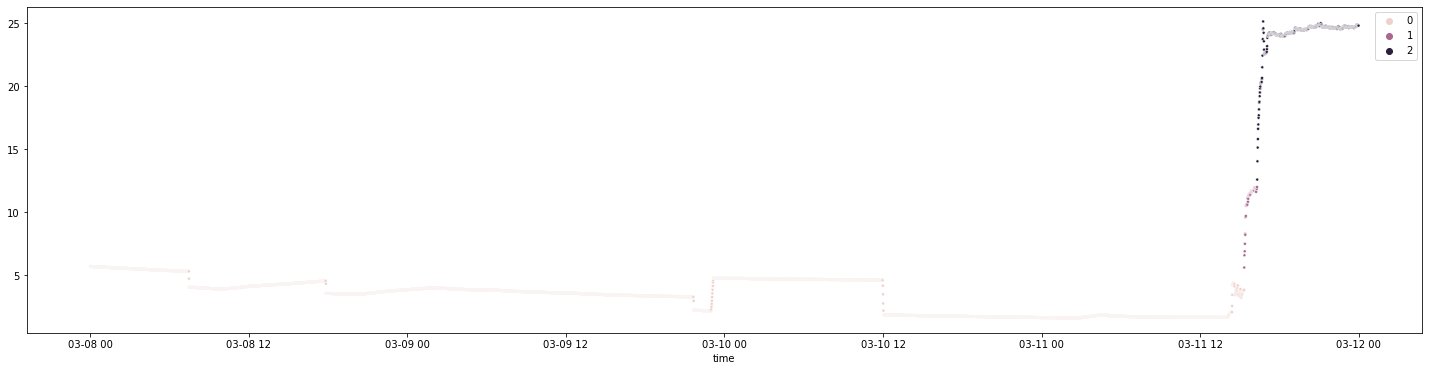

In [11]:
n = 0
t = ((target_split(dfs[n])[0] ** 2).sum(axis=1) ** 0.5) / dfs[n].shape[1]
temp(t, n)
temp(t[(t.index > np.datetime64('2022-03-08')) & (t.index < np.datetime64('2022-03-12'))], n)

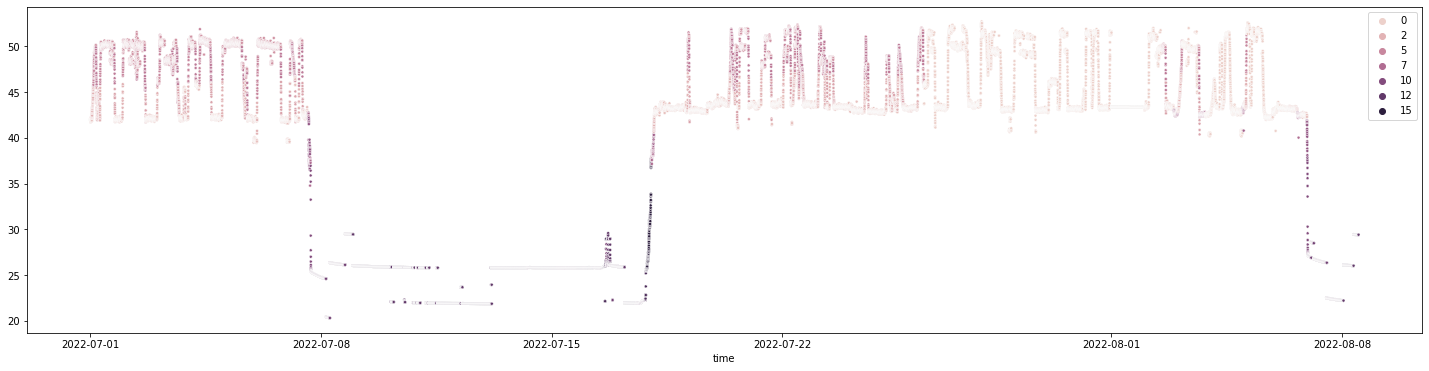

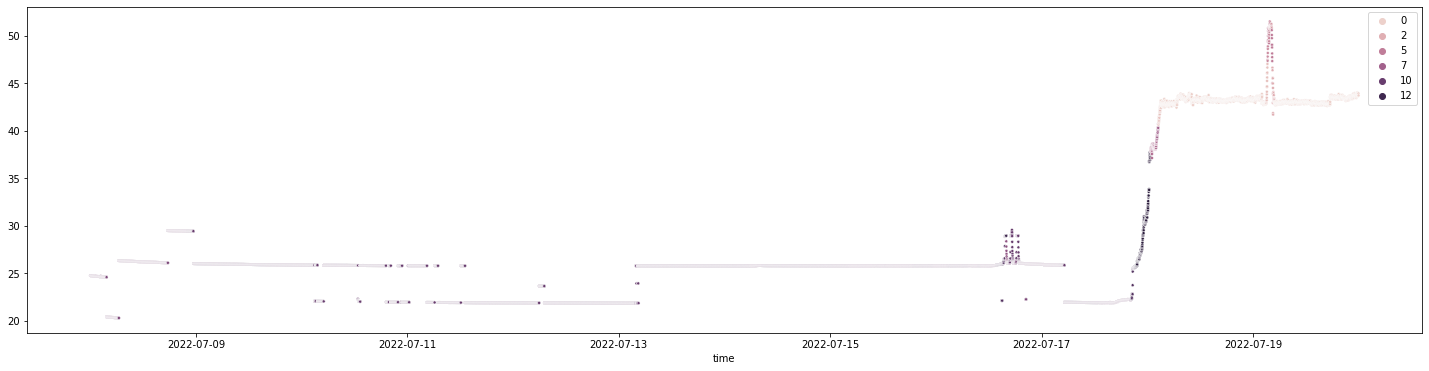

In [12]:
n = 1
t = ((target_split(dfs[n])[0] ** 2).sum(axis=1) ** 0.5) / dfs[n].shape[1]
temp(t, n)
temp(t[(t.index > np.datetime64('2022-07-08')) & (t.index < np.datetime64('2022-07-20'))], n)

Судя по всему останова нет.

#### Проверка что между любыми двумя режимами есть переходный режим

Проверка неактуальна, пояснили на вебинаре: некоторые из обозначенных режимов сами по себе переходные.

In [13]:
# t = (dfs[0][TARGET_FEATURE] + 1).fillna(-1)
# t = pd.concat([t, np.sign(t)], axis=1).diff() != 0
# t = np.logical_xor(t.iloc[:, 0], t.iloc[:, 1])
# if any(t):
#     print('Режимы могут сменяться без переходного процесса.')
#     print(f"Всего таких режимов: {len(dfs[0][TARGET_FEATURE].loc[t[t].index].unique())} из {len(dfs[0][TARGET_FEATURE].unique())}")

#### Проверка наличия иерархии режимов

Предположение состоит в том, что есть ограниченное число возможностей смены режима из конкретного режима. Например, если мы в режиме 1, то можем перейти только в режимы 2 и 3, и ни в какие другие.

На вебинаре косвенно подтвердили что это так.

In [14]:
# def temp(df, bidirect=False):
#     target = df[TARGET_FEATURE].fillna(-1)
#     t = target.diff()
#     t = ((t != 0) & (~pd.isna(t))).reset_index(drop=True)
#     mode_pairs = zip(target.iloc[sorted(t[t].index)], target.iloc[sorted(t[t].index.values - 1)])
#     if bidirect:
#         mode_pairs = map(lambda x: tuple(sorted(x)), map(set, mode_pairs))
#     mode_pairs = sorted(set(mode_pairs), key=lambda x: x[0])
#     mode_pairs = list(map(lambda x: (int(x[0]), int(x[1])), mode_pairs))
#     return mode_pairs

# print(*temp(dfs[0]), end='\n'*2)
# print(*temp(dfs[0], True), end='\n'*2)
# print(*temp(dfs[1]), end='\n'*2)
# print(*temp(dfs[1], True))

#### Всякое

Интересно посмотреть сколько существовал самый короткий режим. По данным, полученным выше, самый редкий режим в сумме занял 13 минут.

In [15]:
t = dfs[0][TARGET_FEATURE]
r = list(map(int, np.sort(np.diff(t.diff().replace(0, nan).dropna().index) * 1e-9)))
print(f"Минимальная длительность режима: {min(r)} с")
print(f"Максимальная длительность режима: {max(r)} с")

Минимальная длительность режима: 120 с
Максимальная длительность режима: 2400360 с


Важный ввод: некоторые режимы могут занимать всего десяток измерений подряд.